In [1]:
import numpy as np 
rng = np.random.default_rng()

import pandas as pd
from tqdm import tqdm

In [2]:
def plot_multiple_runs(data_model):
    groups = data_model.groupby("run")
    for _, g in groups:
        g.index = g["generation"]
        g["p"].plot(lw=.5, ylim=(0,1))

    data_model.groupby("generation")["p"].mean().plot(c="k", lw="1")

In [3]:
def vertical_transmission(N, p_0, b, t_max, r_max):
    # Create the output DataFrame
    output = pd.DataFrame({
        "generation" : np.tile(np.arange(t_max), r_max),
        "p" : [ np.nan ] * t_max * r_max,
        "run" : np.repeat(np.arange(r_max), t_max)
    })

    for r in range(r_max): # r_max
        # Create first generation
        population = pd.DataFrame({"trait": rng.choice(["A", "B"], size=N, replace=True, p=[p_0, 1 - p_0])})

        # Add first generation's p for run r
        output.loc[ r * t_max, "p"] = population[ population["trait"] == "A" ].shape[0] / N

        # For each generation 
        for t in range(t_max): # t_max
            # Copy individuals to previous_population DataFrame
            previous_population = population.copy()

            # randomly pick mothers and fathers
            mother = previous_population["trait"].sample(N, replace=True).reset_index(drop=True)
            father = previous_population["trait"].sample(N, replace=True).reset_index(drop=True)

            # prepare next generation
            population = pd.DataFrame({"trait": [np.nan] * N })

            # Both parents are A, thus child adopts A
            both_A = (mother == "A") & (father == "A")
            # if sum(both_A) > 0:
            population.loc[both_A,"trait"] = "A"

            # Both parents are A, thus child adopts A
            both_B = (mother == "B") & (father == "B")
            # if sum(both_B) > 0:
            population.loc[both_B,"trait"] = "B"

            # If any empty NA slots are present (i.e. one A and one B parent)
            # if population.isna().any():
                # They adopt A with probability b
            remaining = rng.choice(["A", "B"], size=population["trait"].isna().sum(), replace=True, p=[b, 1 - b])
            population.loc[population["trait"].isna(),"trait"] = remaining
            
            # Get p and put it into output slot for this generation t and run r
            output.loc[r * t_max + t, "p"] = population[ population["trait"] == "A" ].shape[0] / N

    return output 

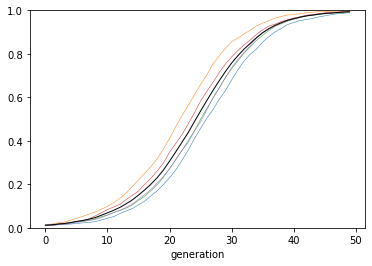

In [4]:
data_model = vertical_transmission(N=10_000, p_0=0.01, b=0.6,t_max=50, r_max=5)
plot_multiple_runs(data_model)

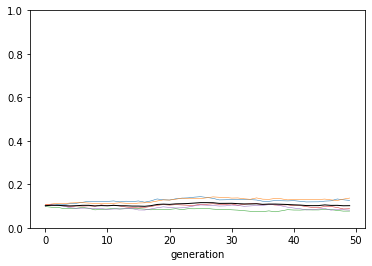

In [5]:
data_model = vertical_transmission(N=10_000, p_0=0.1, b=0.5,t_max=50, r_max=5)
plot_multiple_runs(data_model)

In [6]:
def vertical_horizontal_transmission(N, p_0, b, n, g, t_max, r_max):
    # Create the output DataFrame
    output = pd.DataFrame({
        "generation" : np.tile(np.arange(t_max), r_max),
        "p" : [ np.nan ] * t_max * r_max,
        "run" : np.repeat(np.arange(r_max), t_max)
    })

    for r in range(r_max):
        # Create first generation
        population = pd.DataFrame({"trait": rng.choice(["A", "B"], size=N, replace=True, p=[p_0, 1 - p_0])})

        # Add first generation's p for run r
        output.loc[ r * t_max, "p"] = population[ population["trait"] == "A" ].shape[0] / N

        # For each generation 
        for t in tqdm(range(t_max)):
            ### Vertical transmission =========================================================

            # Copy individuals to previous_population DataFrame
            previous_population = population.copy()

            # randomly pick mothers and fathers # NOTE: With this implementation, an individual could be both mother and father
            mother = previous_population["trait"].sample(N, replace=True).reset_index(drop=True)
            father = previous_population["trait"].sample(N, replace=True).reset_index(drop=True)

            # prepare next generation
            population = pd.DataFrame({"trait": [np.nan] * N }) # should N rather be t_max * r_max?

            # Both parents are A, thus child adopts A
            both_A = (mother == "A") & (father == "A")
            # if sum(both_A) > 0:
            population.loc[both_A,"trait"] = "A"

            # Both parents are A, thus child adopts A
            both_B = (mother == "B") & (father == "B")
            # if sum(both_B) > 0:
            population.loc[both_B,"trait"] = "B"

            # If any empty NA slots are present (i.e. one A and one B parent)
            # if population.isna().any():
                # They adopt A with probability b
            remaining = rng.choice(["A", "B"], size=population["trait"].isna().sum(), replace=True, p=[b, 1 - b])
            population.loc[population["trait"].isna(),"trait"] = remaining

            ### Horizontal transmission =========================================================

            # previous_population = population.copy()
            # # N_B = number of Bs
            N_B = previous_population[previous_population["trait"] == "B"]["trait"].shape[0]

            # if there are B individuals to switch, and n is not zero:
            if (N_B > 0) & (n > 0):
                # for each B individual:
                for i in range(N_B):
                    # Pick n demonstrators
                    demonstrator = previous_population["trait"].sample(n, replace=True).to_frame()
                    # Get probagbility g
                    copy = rng.choice([True, False], size=n, p=[g, 1-g], replace=True)                   
                    # if any demonstrators with A are to be copied
                    if demonstrator[(demonstrator["trait"] == "A") & (copy == True)].shape[0] > 0:
                        # The B individual switches to A
                        idx = previous_population[ previous_population["trait"] == "B"].index[i]
                        population.loc[idx, "trait"] = "A"
                    #     population[previous_population["trait"] == "B"].iloc[i, "trait"] = "A"
            
            # Get p and put it into output slot for this generation t and run r
            output.loc[r * t_max + t, "p"] = population[ population["trait"] == "A" ].shape[0] / N

    return output

In [7]:
vertical_horizontal_transmission(N=5000, p_0=0.01, b=0.5, n=5, g=0.1, t_max=50, r_max=2)

 56%|█████▌    | 28/50 [00:00<00:00, 140.74it/s]

4943
4947
4946
4949
4945
4951
4946
4945
4947
4964
4970
4963
4958
4961
4962
4961
4970
4967
4963
4951
4941
4931
4918
4916
4931
4946
4953
4963
4969


100%|██████████| 50/50 [00:00<00:00, 142.06it/s]


4954
4963
4963
4948
4949
4950
4933
4924
4918
4921
4908
4911
4920
4915
4917
4913
4907
4918
4916
4910
4900


  0%|          | 0/50 [00:00<?, ?it/s]

4963
4959
4966
4964
4967
4962


 48%|████▊     | 24/50 [00:00<00:00, 117.43it/s]

4954
4952
4961
4959
4961
4953
4948
4948
4949
4952
4946
4943
4945
4930
4921
4938
4941
4947
4938
4936
4941
4941
4936
4939
4931


100%|██████████| 50/50 [00:00<00:00, 127.54it/s]

4947
4944
4943
4950
4948
4959
4961
4962
4962
4964
4972
4972
4972
4970
4974
4972
4973
4960
4965


100%|██████████| 50/50 [01:07<00:00,  1.34s/it]


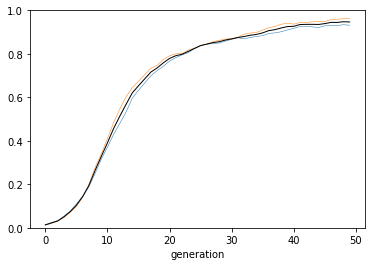

In [275]:
data_model = vertical_horizontal_transmission(N=5000, p_0=0.01, b=0.5, n=5, g=0.1, t_max=50, r_max=2)
plot_multiple_runs(data_model)